# End-to-end housing project

The aim of this project is to predict housing prices in California.

##  Setup

In [1]:
# numerics, tables, ml
import sys
import os
import numpy as np
import pandas as pd
import sklearn

# visualization
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('figure', **{'dpi': 120})
mpl.rc('font', **{'family': 'sans-serif'})
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# destination for the figures
PROJECT_ROOT_DIR = '.'
CHAPTER_ID = 'end_to_end_project'
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, 'images', CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension='pdf', resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + '.' + fig_extension)
    print('Saving figure', fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Download the data

In [2]:
import os
import tarfile
import wget

DOWNLOAD_ROOT = 'https://raw.githubusercontent.com/ageron/handson-ml2/master/'
HOUSING_URL = DOWNLOAD_ROOT + 'datasets/housing/housing.tgz'
HOUSING_PATH = os.path.join('datasets', 'housing')

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    # download the data
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, 'housing.tgz')
    if os.path.exists(tgz_path):
        os.remove(tgz_path)
    wget.download(housing_url, tgz_path)
    # untar the data    
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [3]:
fetch_housing_data()

## Load data and have a quick look at it

In [4]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, 'housing.csv')
    return pd.read_csv(csv_path)

In [5]:
housing = load_housing_data()

In [6]:
housing.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


In [7]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [8]:
# the NaNs have to be dealt with later on
housing[housing.total_bedrooms.isna()].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
290,-122.16,37.77,47.0,1256.0,NaN,570.0,218.0,4.3750,161900.0,NEAR BAY
341,-122.17,37.75,38.0,992.0,NaN,732.0,259.0,1.6196,85100.0,NEAR BAY
538,-122.28,37.78,29.0,5154.0,NaN,3741.0,1273.0,2.5762,173400.0,NEAR BAY
563,-122.24,37.75,45.0,891.0,NaN,384.0,146.0,4.9489,247100.0,NEAR BAY
696,-122.10,37.69,41.0,746.0,NaN,387.0,161.0,3.9063,178400.0,NEAR BAY


In [9]:
# this is a categorigal attribute
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [10]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Saving figure attribute_histogram_plots


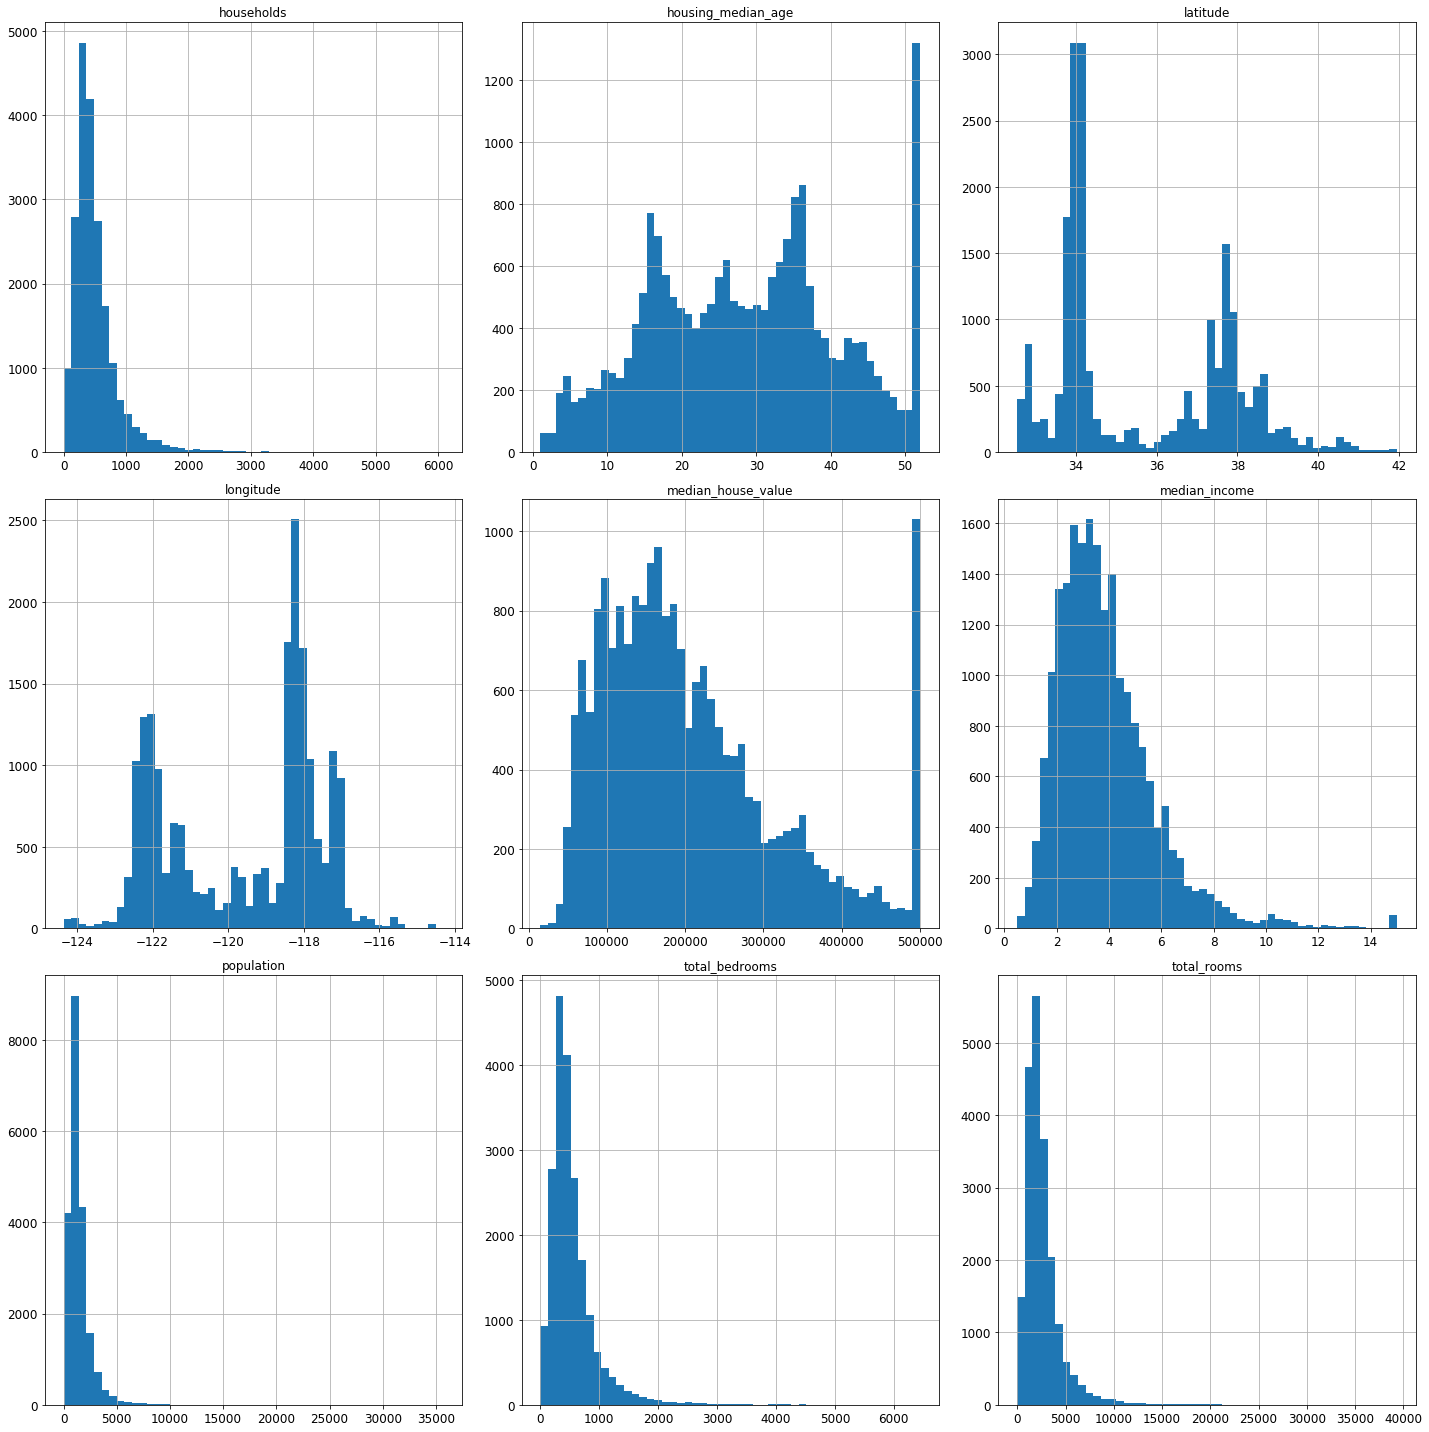

In [11]:
housing.hist(bins=50, figsize=(20, 20))
save_fig('attribute_histogram_plots')
plt.show()

## Split data into a test and train set

### Naive approach

In [12]:
def naive_split_train_test(data, test_ratio, seed=42):
    # this function chooses a different test set once the data is updated
    np.random.seed(seed)
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [13]:
train_set, test_set = naive_split_train_test(housing, 0.2)
print('train set: {}, test set: {}'.format(len(train_set), len(test_set)))

train set: 16512, test set: 4128


In [14]:
train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
14196,-117.03,32.71,33.0,3126.0,627.0,2300.0,623.0,3.2596,103000.0,NEAR OCEAN
8267,-118.16,33.77,49.0,3382.0,787.0,1314.0,756.0,3.8125,382100.0,NEAR OCEAN
17445,-120.48,34.66,4.0,1897.0,331.0,915.0,336.0,4.1563,172600.0,NEAR OCEAN
14265,-117.11,32.69,36.0,1421.0,367.0,1418.0,355.0,1.9425,93400.0,NEAR OCEAN
2271,-119.80,36.78,43.0,2382.0,431.0,874.0,380.0,3.5542,96500.0,INLAND


In [15]:
# identical behavior to the function above
from sklearn.model_selection import train_test_split 
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [16]:
train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
14196,-117.03,32.71,33.0,3126.0,627.0,2300.0,623.0,3.2596,103000.0,NEAR OCEAN
8267,-118.16,33.77,49.0,3382.0,787.0,1314.0,756.0,3.8125,382100.0,NEAR OCEAN
17445,-120.48,34.66,4.0,1897.0,331.0,915.0,336.0,4.1563,172600.0,NEAR OCEAN
14265,-117.11,32.69,36.0,1421.0,367.0,1418.0,355.0,1.9425,93400.0,NEAR OCEAN
2271,-119.80,36.78,43.0,2382.0,431.0,874.0,380.0,3.5542,96500.0,INLAND


### Split by hashing identifiers

In [17]:
import hashlib

In [18]:
def test_set_check(identifier, test_ratio, hash=hashlib.md5):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [19]:
# with such splitting members of the test set will never occur in the train set (if index doesn't change)
housing_with_id = housing.reset_index()   
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'index')

In [20]:
train_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
6,6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY


### Stratified sampling (to avoid bias)

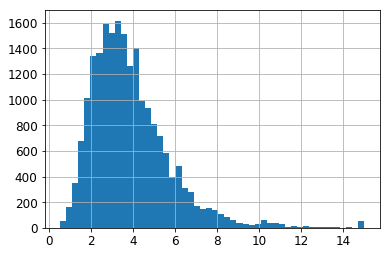

In [21]:
housing['median_income'].hist(bins=50)
plt.show()

In [22]:
# we will categorize the income category and sample on the basis of it
housing['income_cat'] = pd.cut(housing['median_income'],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

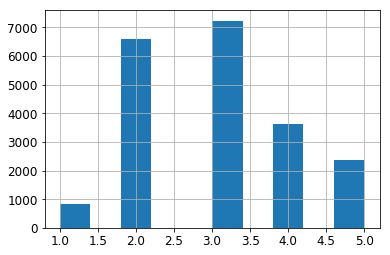

In [23]:
housing['income_cat'].hist()
plt.show()

In [24]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [25]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [26]:
housing["income_cat"].value_counts() / len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

In [27]:
income_cat_proportions = lambda data: data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [28]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.039826,0.039729,0.040213,0.973236,-0.243309
2,0.318847,0.318798,0.324370,1.732260,-0.015195
3,0.350581,0.350533,0.358527,2.266446,-0.013820
4,0.176308,0.176357,0.167393,-5.056334,0.027480
5,0.114438,0.114583,0.109496,-4.318374,0.127011


In [29]:
# we see that in the stratified sample data is not biased

In [30]:
for data in strat_train_set, strat_test_set:
    data.drop(['income_cat'], axis=1, inplace=True)

## Visualization

In [31]:
housing = strat_train_set.copy()

Saving figure california_housing_prices_plot


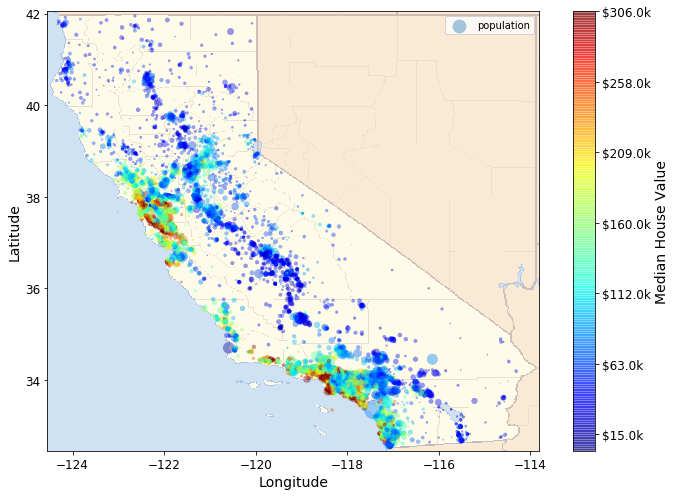

In [32]:
import matplotlib.image as mpimg
california_img=mpimg.imread(PROJECT_ROOT_DIR + '/images/end_to_end_project/california.png')

housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4,
            s=housing['population']/100, figsize=(10, 7),
            c="median_house_value", cmap=plt.get_cmap("jet"), edgecolors=None, linewidths=0.3,
            colorbar=False, sharex=False, label='population')

plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude")
plt.xlabel("Longitude")

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["${}k".format(round(v/1000)) for v in tick_values])
cbar.set_label('Median House Value')

plt.legend()
save_fig("california_housing_prices_plot")
plt.show()

In [33]:
housing['latitude'].min()

32.54

## Look at correlations in the data to extract better features

In [34]:
corr_matrix = housing.corr()

In [35]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

In [38]:
corr_matrix["total_bedrooms"].sort_values(ascending=False)

total_bedrooms        1.000000
households            0.980170
total_rooms           0.929379
population            0.876320
longitude             0.076598
median_house_value    0.047689
median_income        -0.009740
latitude             -0.072419
housing_median_age   -0.325047
Name: total_bedrooms, dtype: float64

In [45]:
housing.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

Saving figure scatter_matrix_plot


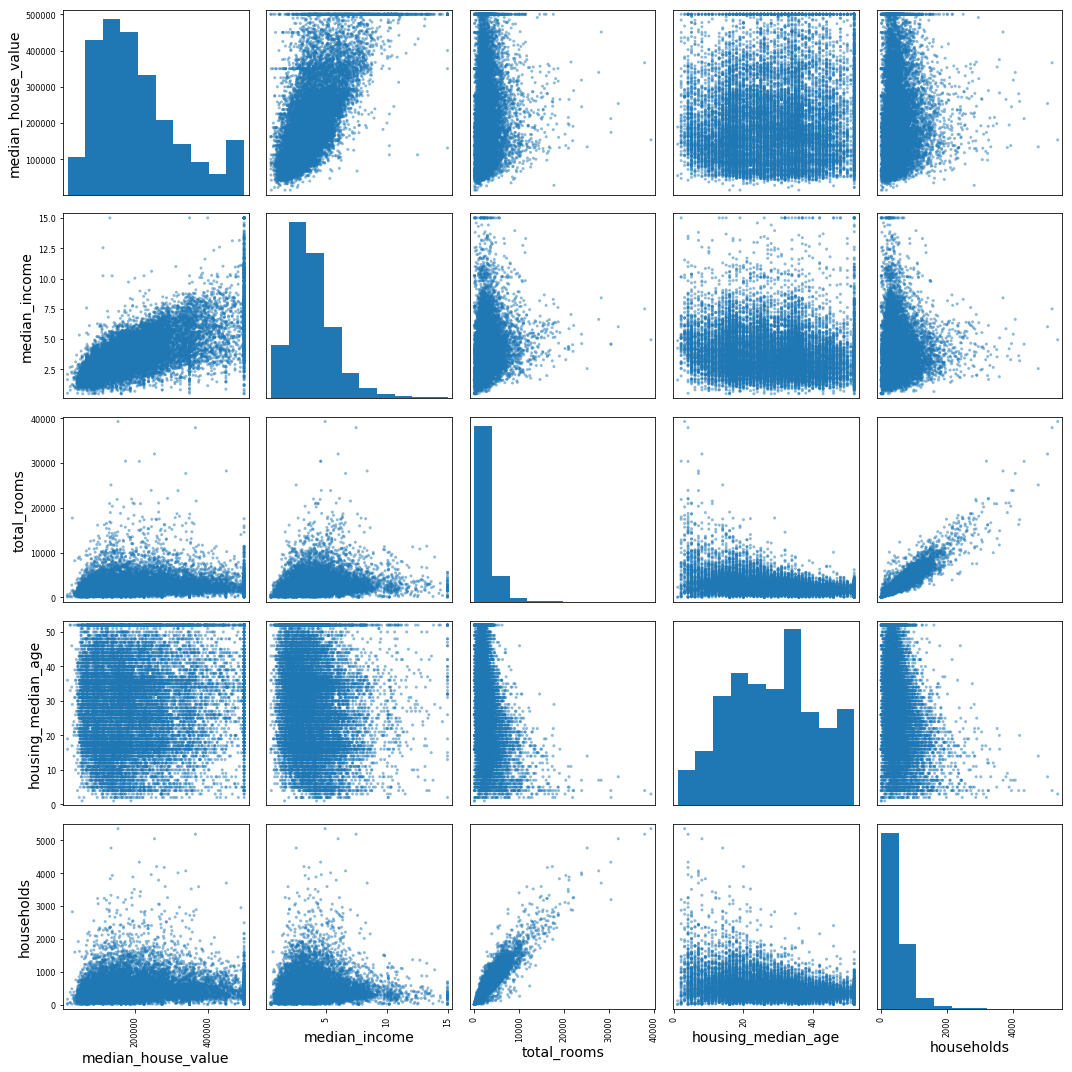

In [48]:
# from pandas.tools.plotting import scatter_matrix # For older versions of Pandas
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age", 'households']
scatter_matrix(housing[attributes], figsize=(15, 15))
save_fig("scatter_matrix_plot")
plt.show()

Saving figure income_vs_house_value_scatterplot


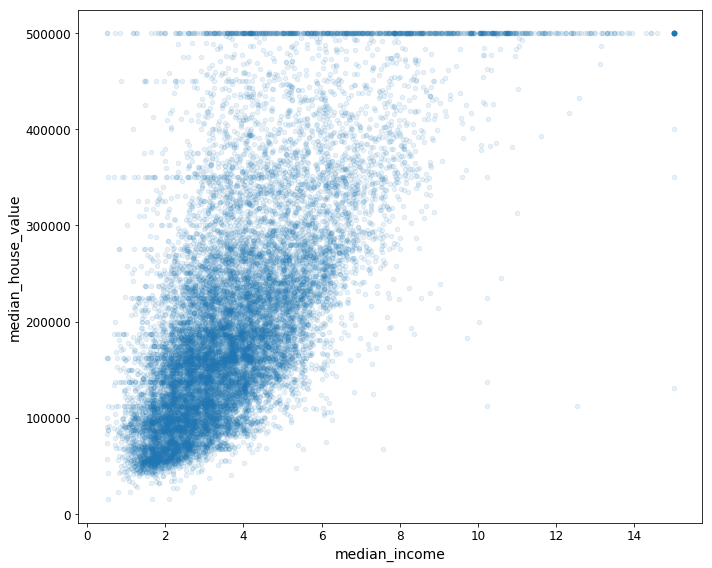

In [56]:
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1, figsize=(10, 8))
save_fig("income_vs_house_value_scatterplot")

In [57]:
# it's better to work with intensive quantities
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [58]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

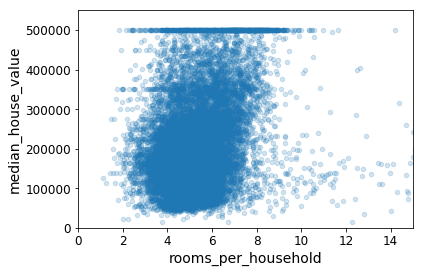

In [63]:
housing.plot(kind="scatter", x="rooms_per_household", y="median_house_value",
             alpha=0.2)
plt.axis([0, 15, 0, 550000])
plt.show()